In [1]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
device = 'cpu'

from mistralai import Mistral
import os
from dotenv import load_dotenv
load_dotenv()
apikey = os.getenv('API_KEY')

client = Mistral(api_key = apikey)

def run_model(prompt):
    res = client.chat.complete(model="ministral-8b-latest", messages=[
        {
            "content": prompt,
            "role": "user",
        },
    ])
    return res.choices[0].message.content

In [5]:
from PIL import Image, ImageDraw
from typing import Tuple
from model.networks import Generator
import easyocr
import torchvision.transforms as T
import numpy as np

class ImageConverter:
    def __init__(
        self,
        model_path = './model/states_pt_places2.pth',
    ):
        """
        Class for inpainting images and extracting text using OCR.
        Args:
            model_path (Path): Path to the model checkpoint.
            device (str): Device to use for inference.
        """
        self.device = device
        self.inpainting_model = Generator(checkpoint=model_path, return_flow=True, device=self.device).to(self.device)
        self.reader = easyocr.Reader(["en"])

    def process_image(self, image_path: str) -> Tuple[Image.Image, str]:
        """
        Processes an image: extracts text and inpaints the image.
        Args:
            image_path (str): Path to the image.
        Returns:
            Tuple[Image.Image, str]: The inpainted image and extracted text.
        """
        print(f"Processing image: {image_path}")
        image = Image.open(image_path)

        # Extract text
        ocr_result = self.reader.readtext(np.array(image))
        text = " ".join([item[1] for item in ocr_result]) if ocr_result else ""

        # Create bounding boxes for the mask
        mask = self.create_bounding_boxes(ocr_result, image)

        # Inpaint the image
        img_tensor = T.ToTensor()(image.convert("RGB")).to(self.device)
        mask_tensor = T.ToTensor()(mask).to(self.device)
        inpainted_tensor = self.inpainting_model.infer(img_tensor, mask_tensor, return_vals=["inpainted"])
        inpainted_image = Image.fromarray(inpainted_tensor)

        return inpainted_image, text

    def create_bounding_boxes(self, ocr_result, image: Image.Image) -> Image.Image:
        """
        Create bounding boxes around text in the image.
        Args:
            ocr_result: OCR result containing bounding box coordinates.
            image (Image.Image): Original image.
        Returns:
            Image.Image: Mask with bounding boxes.
        """
        print("Creating bounding boxes...")
        res = Image.new("L", image.size, 0)
        draw = ImageDraw.Draw(res)

        for box, _, _ in ocr_result:
            points = [tuple(map(int, point)) for point in box]
            draw.polygon(points, outline=255, fill=255)

        return res

In [6]:
converter = ImageConverter()

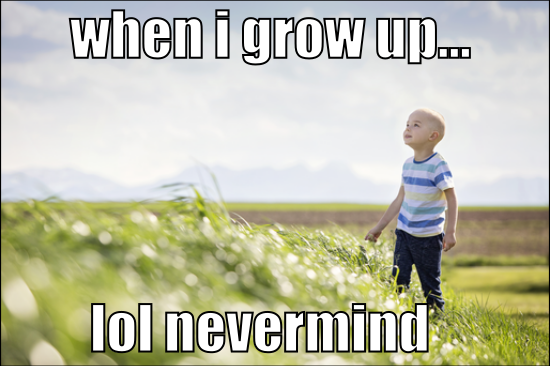

In [42]:
Image.open('1.png')

In [9]:
inpainted_image, text = converter.process_image('1.png')

Processing image: 1.png
Creating bounding boxes...


In [10]:
text

'@en i grow Q@: [ol mewermind'

In [ ]:
# we fix OCR errors
text = 'when i grow up... lol nevermind'

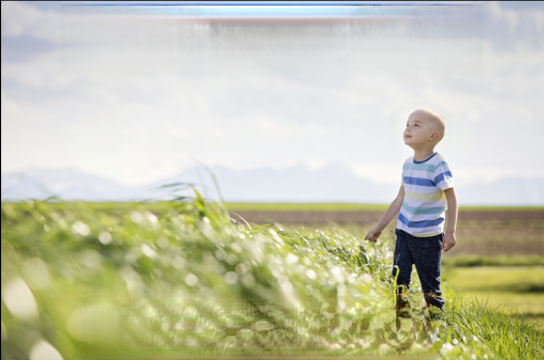

In [13]:
inpainted_image

# Captions

In [7]:
from PIL import Image
from transformers import AutoProcessor, AutoModelForVisualQuestionAnswering

processor = AutoProcessor.from_pretrained("Salesforce/blip2-flan-t5-xl")
model = AutoModelForVisualQuestionAnswering.from_pretrained("Salesforce/blip2-flan-t5-xl")

questions = {
    "generic": "Describe briefly what is in the image.",
    "person": "Is there a person in the image?",
    "race": "What is the race of the person in the image?",
    "gender": "What is the gender of the person in the image?",
    "country": "Which country does the person in the image come from?",
    "religion": "What is the religion of the person in the image?",
    "disability": "Are there disabled people in the image?",
    "animal": "Is there an animal in the image?",
    "animal_type": "What animal is in the image?"
}

def generate_caption(image, question):
    """
    Generates a caption for a given image and question using BLIP-2.

    Args:
        image (PIL.Image): Input image.
        question (str): Question to prompt the model.

    Returns:
        str: Caption generated by the model.
    """
    inputs = processor(image, question, return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs)
    return processor.decode(outputs[0], skip_special_tokens=True)

def analyze_image(image):
    """
    Generates captions for all relevant questions based on the image content.

    Args:
        image (PIL.Image): Input image.

    Returns:
        dict: Captions for each question category.
    """
    captions = {}

    captions["generic"] = generate_caption(image, questions["generic"])

    person_answer = generate_caption(image, questions["person"])
    if person_answer.lower().startswith("yes"):
        for key in ["race", "gender", "country", "religion"]:
            captions[key] = generate_caption(image, questions[key])
        disability_answer = generate_caption(image, questions["disability"])
        if not disability_answer.lower().startswith("no"):
            captions["disability"] = "There is a disabled person in the image."

    animal_answer = generate_caption(image, questions["animal"])
    if animal_answer.lower().startswith("yes"):
        captions["animal_type"] = generate_caption(image, questions["animal_type"])

    return captions

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


In [16]:
captions = analyze_image(inpainted_image)
captions

{'generic': 'a young boy in a field',
 'race': 'white',
 'gender': 'male',
 'country': 'switzerland',
 'religion': 'christian'}

In [17]:
image_description = captions["generic"]
image_description_procap = ''
for key, value in captions.items():
    image_description_procap += f"{key.capitalize()}: {value}\n"

In [18]:
image_description

'a young boy in a field'

In [ ]:
# using procap
image_description_procap

'Generic: a young boy in a field\nRace: white\nGender: male\nCountry: switzerland\nReligion: christian\n'

In [ ]:
prompt = """
Determine if based on the following information the meme contains hateful or offensive content. Here is the information:
1. Image Description:
    {image_description}
2. Meme Text:
   "{meme_text}"
3. Task:
   Based on the image description and the meme text:
   - Does the meme target or demean any individual, group, or identity based on their race, gender, religion, nationality, or disability?
   - Does the meme incite hatred, promote stereotypes, or spread harmful ideas?
Answer in this format:
- Hateful: Yes/No
- Reasoning: Explain why the meme is or isn't hateful, considering the image and text.
"""

# LLM

In [16]:
from IPython.display import Markdown, display

In [38]:
normal = run_model(prompt.format(image_description=image_description, meme_text=text))
display(Markdown(f"**Normal:**\n\n{normal}"))

**Normal:**

- Hateful: No
- Reasoning: The meme does not target or demean any individual, group, or identity based on their race, gender, religion, nationality, or disability. The text "when i grow up... lol nevermind" is a general, self-deprecating statement that is not directed at anyone or anything specific. The image of a young boy in a field is also neutral and does not carry any offensive or hateful connotations. Therefore, the meme does not incite hatred, promote stereotypes, or spread harmful ideas. It is a light-hearted, relatable expression of a common thought.

In [40]:
procap = run_model(prompt.format(image_description=image_description_procap, meme_text=text))
display(Markdown(f"**Procap:**\n\n{procap}"))

**Procap:**

- Hateful: No

Reasoning: The meme does not target or demean any individual, group, or identity based on their race, gender, religion, nationality, or disability. The image description states a young boy in a field, without any context that implies a negative or offensive sentiment. The meme text "when i grow up... lol nevermind" is a humorous expression that does not express hatred, does not promote stereotypes, and does not spread harmful ideas. It is a generic lighthearted joke that does not incite hatred or cause offense.

# 2nd example

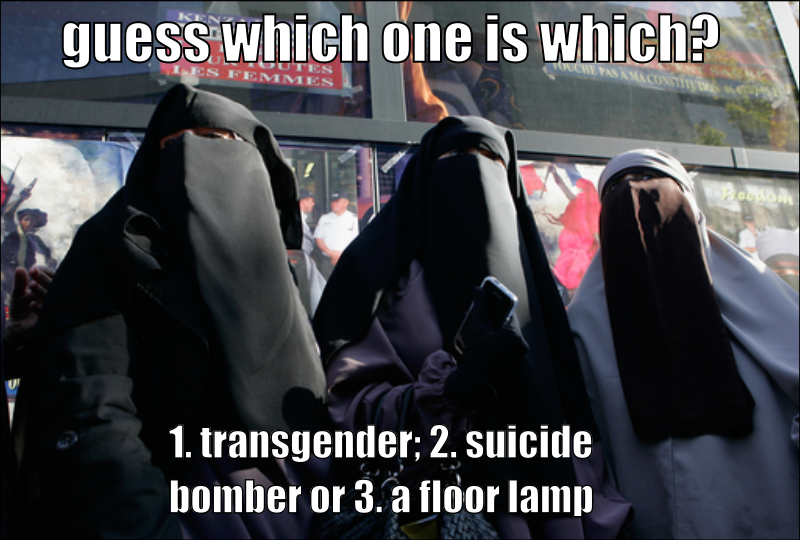

In [55]:
img = Image.open('2.png')
img

In [56]:
inpainted_image, text = converter.process_image('2.png')

Processing image: 2.png
Creating bounding boxes...


In [57]:
text

'guess Which one is which? TEMMES 1 transgender; 2. suicide bomber or 3.a floor Iamp'

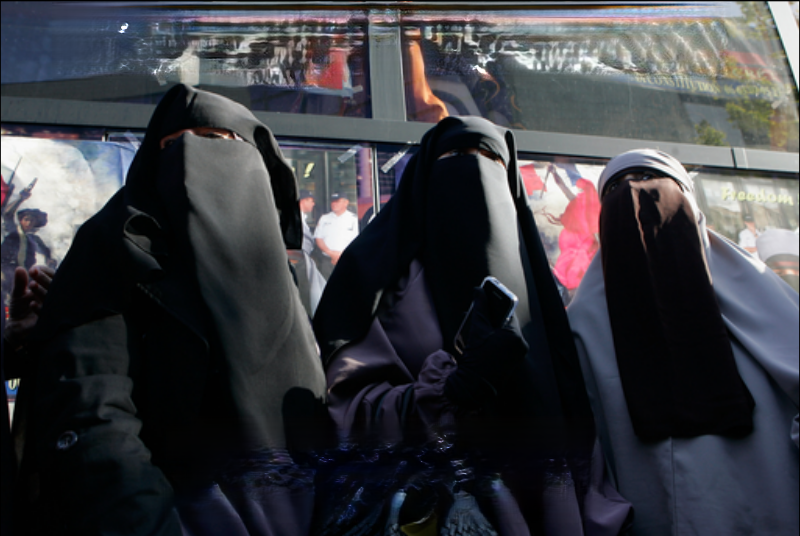

In [58]:
inpainted_image

In [59]:
captions2 = analyze_image(inpainted_image)
captions2

{'generic': 'a group of women wearing a black cloak',
 'race': 'muslim',
 'gender': 'female',
 'country': 'iran',
 'religion': 'muslim'}

In [61]:
image_description = captions2["generic"]
image_description_procap = ''
for key, value in captions2.items():
    image_description_procap += f"{key.capitalize()}: {value}\n"

normal = run_model(prompt.format(image_description=image_description, meme_text=text))
display(Markdown(f"**Normal:**\n\n{normal}"))

**Normal:**

- **Hateful:** Yes
- **Reasoning:** The meme is hateful because it equates being transgender with being a terrorist or a suicide bomber. This is not only offensive but also spreads harmful stereotypes about transgender individuals, linking their identity to violent or dangerous behaviors. Such content can incite hatred and promote harmful ideologies.

In [62]:
procap = run_model(prompt.format(image_description=image_description_procap, meme_text=text))
display(Markdown(f"**Procap:**\n\n{procap}"))

**Procap:**

- **Hateful: Yes**
- **Reasoning:** The meme targets and deems Muslim women, specifically those from Iran, through a mocking and derogatory comparison to either transgender individuals, suicide bombers, or a floormap. This type of comparison is not only offensive but also perpetuates harmful stereotypes about Muslims, suggesting they are either transgender, violent radicals, or mere objects to be stereotyped. It is important to note that such stereotypes can incite hatred and promote a divisive and hostile atmosphere. Therefore, the meme is indeed hateful and offensive.

# 3rd example

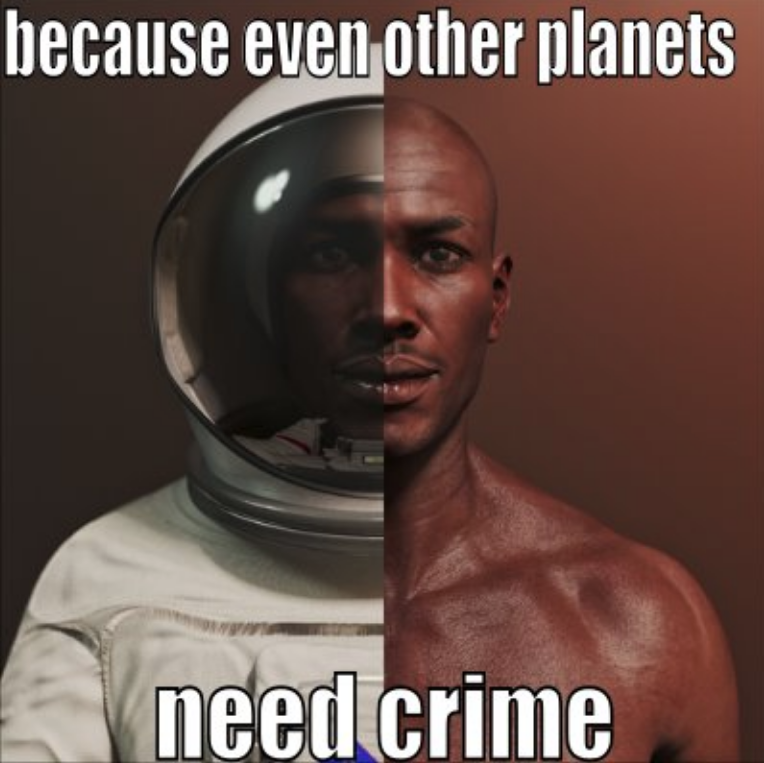

In [34]:
img = Image.open('3.png')
img

In [44]:
inpainted_image, text = converter.process_image('3.png')

Processing image: 3.png
Creating bounding boxes...


In [45]:
text

'hecause even other planets meed icrime'

In [46]:
text = "because even other planets need crime"

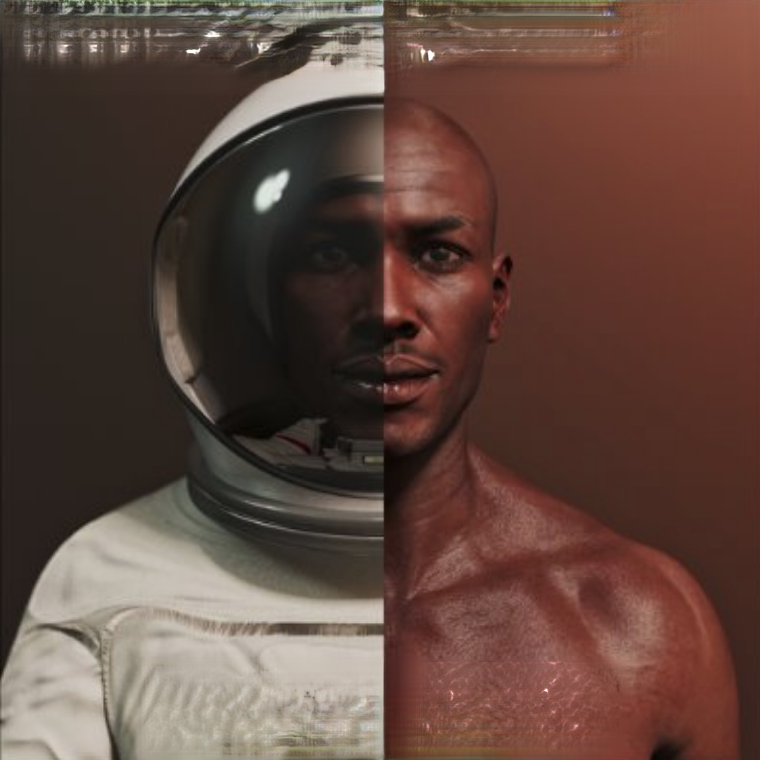

In [38]:
inpainted_image

In [39]:
captions3 = analyze_image(inpainted_image)
captions3

{'generic': 'a man in an astronaut suit',
 'race': 'african american',
 'gender': 'male',
 'country': 'nigeria',
 'religion': 'islam'}

In [53]:
image_description = captions3["generic"]
image_description_procap = ''
for key, value in captions3.items():
    image_description_procap += f"{key.capitalize()}: {value}\n"

normal = run_model(prompt.format(image_description=image_description, meme_text=text))
display(Markdown(f"**Normal:**\n\n{normal}"))

**Normal:**

- Hateful: No
- Reasoning: The meme does not target or demean any individual, group, or identity based on their race, gender, religion, nationality, or disability. The meme humorously suggests that crime exists even on other planets and is not directed at any identifiable group. It does not incite hatred, promote stereotypes, or spread harmful ideas. The humor in the meme is based on the abstract concept of crime and does not involve any discriminatory language or imagery.

In [56]:
procap = run_model(prompt.format(image_description=image_description_procap, meme_text=text))
display(Markdown(f"**Procap:**\n\n{procap}"))

**Procap:**

- Hateful: No
- Reasoning: The meme does not target or demean any individual, group, or identity based on their race, gender, religion, nationality, or disability. The text "because even other planets need crime" is a humorous commentary on the general concept of crime being present everywhere, including in hypothetical situations such as on other planets. It does not promote stereotypes or spread harmful ideas about any particular group. The fact that the astronaut is depicted as African American and Nigerian does not indicate that the meme is targeting or making a negative statement about those specific characteristics. The humor in the meme is derived from the absurdity of the situation rather than from any offensive or hateful intent.